# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [2]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-01-12 10:41:44--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  29.1MB/s    in 7.1s    

2021-01-12 10:41:51 (24.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-01-12 10:41:51--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  38.1MB/s    in 1.6s    

2021-01-12 10:41:53 (38.1 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-01-12 10:41:53--
Total wall clock time: 9.0s
Downloaded: 2 files, 235M i

In [3]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
nn_model = nn.Sequential(                         #3x32x32
            nn.Conv2d(3, 64, 3, padding=1),       #64x32x32
            nn.ReLU(inplace=True),                #64x32x32
            nn.MaxPool2d(4),                      #64x8x8
            nn.Conv2d(64, 64, 3, padding=1),      #64x8x8
            nn.ReLU(inplace=True),                #64x8x8
            nn.MaxPool2d(4),                      #64x2x2
            Flattener(),                          #64*2*2x1x1
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode

    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

    return float(correct_samples) / total_samples
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    # raise Exception("Not implemented")

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.410763, Train accuracy: 0.528086, Val accuracy: 0.715378
Average loss: 0.719593, Train accuracy: 0.781456, Val accuracy: 0.775169
Average loss: 0.610382, Train accuracy: 0.816640, Val accuracy: 0.830865
Average loss: 0.567428, Train accuracy: 0.831007, Val accuracy: 0.816736
Average loss: 0.528010, Train accuracy: 0.841450, Val accuracy: 0.844311


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [10]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

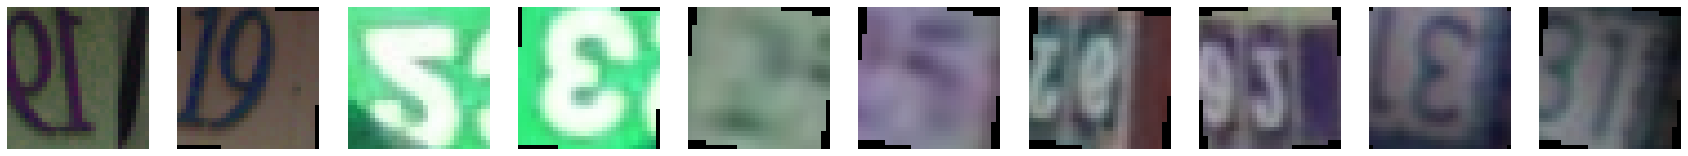

In [11]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [12]:
# TODO: 
tfs2 = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    # transforms.RandomVerticalFlip(),
    # TODO: Add good augmentations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train_2 = dset.SVHN('./', 
                       transform=tfs2
                      )

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = torch.utils.data.DataLoader(data_aug_train_2, batch_size=batch_size, 
                                           sampler=train_sampler)

In [13]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.521036, Train accuracy: 0.844982, Val accuracy: 0.842468
Average loss: 0.497476, Train accuracy: 0.851500, Val accuracy: 0.845881
Average loss: 0.483406, Train accuracy: 0.855970, Val accuracy: 0.853594
Average loss: 0.466781, Train accuracy: 0.860373, Val accuracy: 0.863968
Average loss: 0.459985, Train accuracy: 0.862983, Val accuracy: 0.861306


In [14]:
data_aug_train_2.data.shape

(73257, 3, 32, 32)

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [15]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(                       #3x32x32
            nn.Conv2d(3, 6, 5, padding=0),         #6x28x28
            nn.ReLU(inplace=True),                 #6x28x28
            nn.MaxPool2d(2),                       #6x14x14
            nn.Conv2d(6, 16, 5, padding=0),        #16x10x10
            nn.ReLU(inplace=True),                 #16x10x10
            nn.MaxPool2d(2),                       #16x5x5
            nn.Conv2d(16, 120, 5, padding=0),      #120x1x1
            nn.ReLU(inplace=True),                 #120x1x1
            Flattener(),                           
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [16]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.228518, Train accuracy: 0.587670, Val accuracy: 0.832981
Average loss: 0.510850, Train accuracy: 0.845579, Val accuracy: 0.868541
Average loss: 0.410852, Train accuracy: 0.877180, Val accuracy: 0.878370
Average loss: 0.360911, Train accuracy: 0.892775, Val accuracy: 0.873524
Average loss: 0.320828, Train accuracy: 0.902706, Val accuracy: 0.883762
Average loss: 0.292999, Train accuracy: 0.911613, Val accuracy: 0.890929
Average loss: 0.269732, Train accuracy: 0.917807, Val accuracy: 0.890861
Average loss: 0.252380, Train accuracy: 0.922687, Val accuracy: 0.877346
Average loss: 0.233784, Train accuracy: 0.928147, Val accuracy: 0.887721
Average loss: 0.218132, Train accuracy: 0.932311, Val accuracy: 0.884581


# Подбор гиперпараметров

In [17]:
def train_model_lr_schedule(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size, gamma):    
    loss_history = []
    train_history = []
    val_history = []

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma, last_epoch=-1, verbose=False)

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        scheduler.step()

    return loss_history, train_history, val_history

In [33]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1]#[1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 
# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

for i in reversed(learning_rates):
    for k in anneal_epochs:
        for j in reg:
              print(f"Now running parameters: lr = {i}, anneal_epochs = {k}, reg = {j}")
              lenet_model = nn.Sequential(             #3x32x32
                nn.Conv2d(3, 6, 5, padding=0),         #6x28x28
                nn.ReLU(inplace=True),                 #6x28x28
                nn.MaxPool2d(2),                       #6x14x14
                nn.Conv2d(6, 16, 5, padding=0),        #16x10x10
                nn.ReLU(inplace=True),                 #16x10x10
                nn.MaxPool2d(2),                       #16x5x5
                nn.Conv2d(16, 120, 5, padding=0),      #120x1x1
                nn.ReLU(inplace=True),                 #120x1x1
                Flattener(),                           
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.Linear(84, 10),
                )
              lenet_model.type(torch.cuda.FloatTensor)
              lenet_model.to(device)
              optimizer = optim.SGD(lenet_model.parameters(), lr=i, weight_decay=j)
              loss_history, train_history, val_history = train_model_lr_schedule(
                  lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, k, 0.2)
              run_record[Hyperparams(i,k,j)] = RunResult(lenet_model, train_history, val_history, val_history[-1])
              
# TODO: Your code here!

Now running parameters: lr = 0.1, anneal_epochs = 1, reg = 0.001
Average loss: 1.284900, Train accuracy: 0.567519, Val accuracy: 0.824927
Average loss: 0.476443, Train accuracy: 0.858206, Val accuracy: 0.858440
Average loss: 0.419736, Train accuracy: 0.876258, Val accuracy: 0.865060
Average loss: 0.408769, Train accuracy: 0.879415, Val accuracy: 0.866767
Average loss: 0.406031, Train accuracy: 0.881138, Val accuracy: 0.867176
Now running parameters: lr = 0.1, anneal_epochs = 1, reg = 0.0001
Average loss: 1.271227, Train accuracy: 0.573303, Val accuracy: 0.817146
Average loss: 0.463802, Train accuracy: 0.862198, Val accuracy: 0.866903
Average loss: 0.404101, Train accuracy: 0.879910, Val accuracy: 0.874138
Average loss: 0.392551, Train accuracy: 0.883920, Val accuracy: 0.874480
Average loss: 0.389973, Train accuracy: 0.884585, Val accuracy: 0.874957
Now running parameters: lr = 0.1, anneal_epochs = 1, reg = 1e-05
Average loss: 1.311198, Train accuracy: 0.559345, Val accuracy: 0.820422
A

In [35]:
# run_record
#Now running parameters: lr = 0.1, anneal_epochs = 5, reg = 0.001


In [34]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.89, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [35]:
best_model = nn.Sequential(                            #3x32x32
                nn.Conv2d(3, 6, 5, padding=0),         #6x28x28
                nn.ReLU(inplace=True),                 #6x28x28
                nn.MaxPool2d(2),                       #6x14x14
                nn.Conv2d(6, 16, 5, padding=0),        #16x10x10
                nn.ReLU(inplace=True),                 #16x10x10
                nn.MaxPool2d(2),                       #16x5x5
                nn.Conv2d(16, 120, 5, padding=0),      #120x1x1
                nn.ReLU(inplace=True),                 #120x1x1
                Flattener(), 
                nn.BatchNorm1d(120),                          
                nn.Linear(120, 84),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(84),
                nn.Linear(84, 10),
                )

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(best_model.parameters(), lr=1e-1, weight_decay=1e-05)
# optimizer = torch.optim.Adamax(nn_model.parameters(), lr=1e-1, betas=(0.9, 0.999), eps=1e-08)
loss_history, train_history, val_history = train_model_lr_schedule(
                  best_model, train_aug_loader, val_loader, loss, optimizer, 10, 5, 0.2)

Average loss: 0.944951, Train accuracy: 0.692267, Val accuracy: 0.854276
Average loss: 0.498076, Train accuracy: 0.844913, Val accuracy: 0.865879
Average loss: 0.430789, Train accuracy: 0.867744, Val accuracy: 0.883216
Average loss: 0.425949, Train accuracy: 0.869689, Val accuracy: 0.876254
Average loss: 0.408816, Train accuracy: 0.873238, Val accuracy: 0.890929
Average loss: 0.328815, Train accuracy: 0.899686, Val accuracy: 0.899188
Average loss: 0.313660, Train accuracy: 0.905692, Val accuracy: 0.898300
Average loss: 0.306401, Train accuracy: 0.907723, Val accuracy: 0.901235
Average loss: 0.298879, Train accuracy: 0.909907, Val accuracy: 0.898983
Average loss: 0.294614, Train accuracy: 0.909822, Val accuracy: 0.899324


In [21]:
PATH = 'sgd_trained_net.pth'
torch.save(best_model.state_dict(), PATH)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [36]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    with torch.no_grad():
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

    return float(correct_samples) / total_samples

# TODO Write the code to compute accuracy on test set
# data_test.to(device)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
# for inputs, labels in test_loader:
#     inputs, labels = inputs.to(device), labels.to(device)
# test_loader.to(device)
# print("Test accuracy: %2.4f" % test_accuracy)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)


Final test accuracy -  0.8897894898586355
